In [20]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import cv2
from scipy.sparse.linalg import eigsh
plt.rcParams["figure.figsize"] = (20,12)

In [21]:
# ------------------------------------------------------ A ------------------------------------------------------#
def patch_extract(img,kernel=(8,8)):
    print("Orginal image shape:",img.shape)
    patch = []
    # select pixels as kernel of 8*8 
    for i in range(0,img.shape[0],kernel[0]):
        for j in range(0,img.shape[1],kernel[1]):
            # select arear with given size of height and width
            select_area = img[i:i+kernel[0],j:j+kernel[1]]
            
            # select only one channel (are channels are equal)
            for m in range(kernel[0]):
                for n in range(kernel[1]):
                    select_area[m][n] = select_area[m][n][0]
                    if select_area[m][n][0] != select_area[m][n][1] or select_area[m][n][0]!=select_area[m][n][2]:
                        raise ValueError("Channels are not equal")
            
            #resize the selected pixels to a 1D vector
            resize_to_vector = np.resize(select_area,(kernel[0]*kernel[1]))
            
            # store the vector
            patch.append(resize_to_vector)
    tmp = np.transpose(np.array(patch), (1, 0))
    print("Patch image shape:",tmp.shape)
    # transpose and return the patch
    return tmp
            

img = cv2.imread("./inputs/P4/donald.png")
new_img = patch_extract(img)

Orginal image shape: (600, 448, 3)
Patch image shape: (64, 4200)


In [14]:
# ------------------------------------------------------ B ------------------------------------------------------#
#calculate eigens
pca = PCA(n_components=20).fit(np.cov(new_img))
eigenvalues,eigenvectors = pca.explained_variance_,pca.components_

# printing eigenvalues and eigenvectors
for i in range(20):
    print("EigenValue #{0}:".format(i+1),eigenvalues[i])
    print("EigenVactor #{0}:".format(i+1),eigenvectors[i],end="\n=========================\n")
    


EigenValue #1: 322796.022754078
EigenVactor #1: [-0.17575255 -0.17575255 -0.17575255 -0.14130039 -0.14130039 -0.14130039
 -0.08568172 -0.08568172 -0.08568172 -0.0201217  -0.0201217  -0.0201217
  0.04061374  0.04061374  0.04061374  0.09847024  0.09847024  0.09847024
  0.14772367  0.14772367  0.14772367  0.1817024   0.1817024   0.1817024
 -0.18718482 -0.18718482 -0.18718482 -0.15477251 -0.15477251 -0.15477251
 -0.09928899 -0.09928899 -0.09928899 -0.03017829 -0.03017829 -0.03017829
  0.03555169  0.03555169  0.03555169  0.09614193  0.09614193  0.09614193
  0.14731984  0.14731984  0.14731984  0.1793578   0.1793578   0.1793578
 -0.18794048 -0.18794048 -0.18794048 -0.15516924 -0.15516924 -0.15516924
 -0.10366298 -0.10366298 -0.10366298 -0.0383828  -0.0383828  -0.0383828
  0.02519829  0.02519829  0.02519829  0.08038351]
EigenValue #2: 89799.26783077631
EigenVactor #2: [-0.02359873 -0.02359873 -0.02359873 -0.06972251 -0.06972251 -0.06972251
 -0.12999983 -0.12999983 -0.12999983 -0.16814303 -0.16

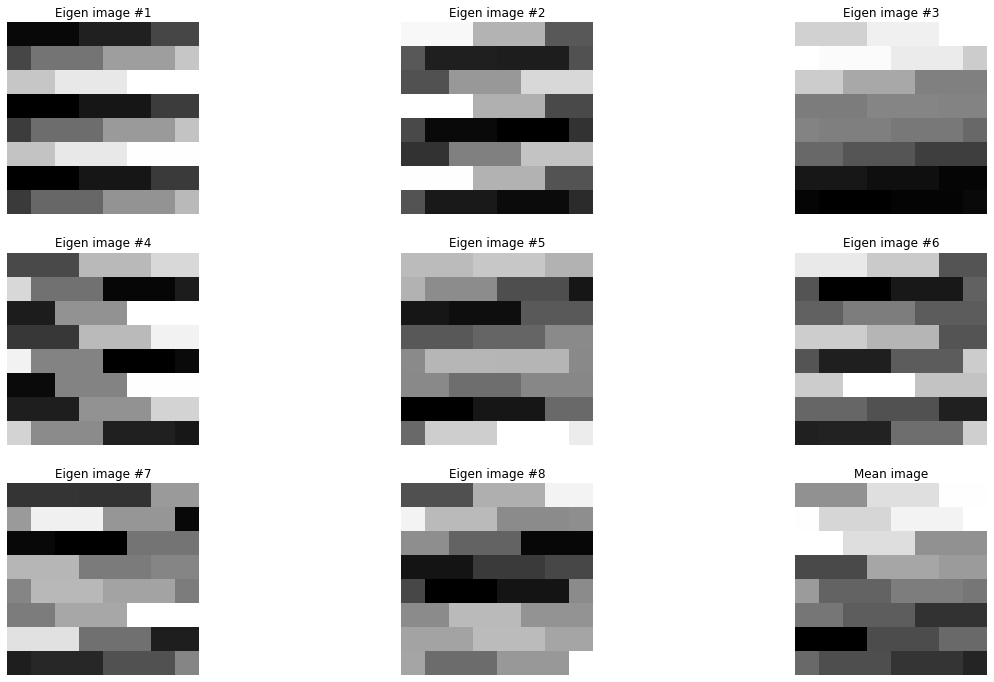

In [26]:
# displaying eigenimages
for index in range(8):
    plt.subplot(3,3,index+1)
    tmp_img = np.resize(eigenvectors[index],(8,8))
    plt.title("Eigen image #{0}".format(index+1))
    plt.axis('off')
    plt.imshow(tmp_img,cmap='gray')
index +=1    
plt.subplot(3,3,index+1)
row_means = new_img.mean(axis=1)
plt.imshow(np.resize(row_means,(8,8)),cmap='gray')
plt.title("Mean image")
plt.axis('off')
plt.show()


In [27]:
 # ------------------------------------------------------ C ------------------------------------------------------#
K = [2,5,10,20]

#compressed images
Compressed = []
for i in range(4):
    print("Compressed Shape: ",np.dot(eigenvectors[:K[i]],new_img).shape)
    Compressed.append(np.dot(eigenvectors[:K[i]],new_img))
    
print("Compressed Shape(mean): ",np.dot(row_means,new_img).shape)
Compressed.append(np.dot(row_means,new_img))

Compressed Shape:  (2, 4200)
Compressed Shape:  (5, 4200)
Compressed Shape:  (10, 4200)
Compressed Shape:  (20, 4200)
Compressed Shape(mean):  (4200,)


In [28]:
 # ------------------------------------------------------ D ------------------------------------------------------#
Uncompress = []
for i in range(4):
    print("Uncompressed Shape: ",np.dot(eigenvectors[:K[i]].T,Compressed[i]).shape)
    Uncompress.append(np.dot(eigenvectors[:K[i]].T,Compressed[i]))
    
print("Uncompressed Shape(Mean): ",np.dot(np.resize(Compressed[4],(4200,1)),np.resize(row_means,(1,64))).T.shape)
Uncompress.append(np.dot(np.resize(Compressed[4],(4200,1)),np.resize(row_means,(1,64))).T)

Uncompressed Shape:  (64, 4200)
Uncompressed Shape:  (64, 4200)
Uncompressed Shape:  (64, 4200)
Uncompressed Shape:  (64, 4200)
Uncompressed Shape(Mean):  (64, 4200)


Input image shape: (4200, 64)
Output image shape: (600, 448)
Input image shape: (4200, 64)
Output image shape: (600, 448)
Input image shape: (4200, 64)
Output image shape: (600, 448)
Input image shape: (4200, 64)
Output image shape: (600, 448)
Input image shape: (4200, 64)
Output image shape: (600, 448)


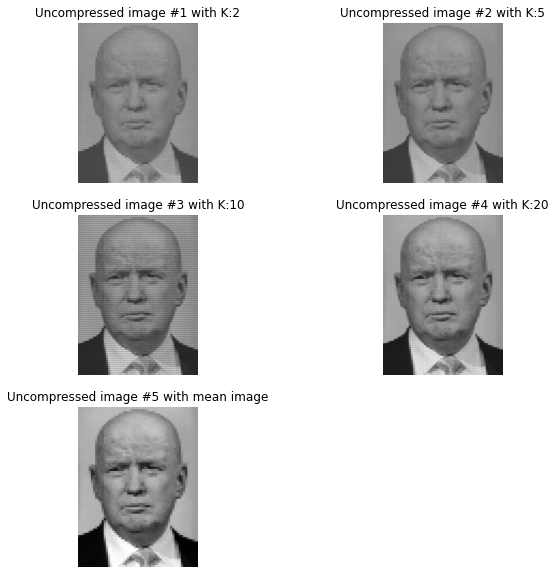

In [30]:
 # ------------------------------------------------------ E ------------------------------------------------------#
plt.rcParams["figure.figsize"] = (10,10)
def patch_reconstruct(img,kernel=(8,8),orginal=(600, 448)):
    #transpose input image to each patch will be in one row
    img = np.transpose(np.array(img), (1, 0))
    
    #Create blank image
    blank_img = np.zeros(orginal)
    
    print("Input image shape:",img.shape)
    index = 0
    
    for i in range(int(orginal[0]/kernel[0])): # count of kernel that scroll into row pixels
        for j in range(int(orginal[1]/kernel[1])):# count of kernel that scroll into col pixels
            
            #reshape 1*64 to 8*8 and replace with blank pixels
            blank_img[i*8:i*8+kernel[0],j*8:j*8+kernel[1]] = np.reshape(img[index],kernel)
            index+=1
            
    print("Output image shape:",blank_img.shape)
    # transpose and return the patch
    return blank_img


# printing uncopressed images
for index in range(4):
    plt.subplot(3,2,index+1)
    plt.title("Uncompressed image #{0} with K:{1}".format(index+1,K[index]))
    plt.axis('off')
    tmp = patch_reconstruct(Uncompress[index])
    plt.imshow(np.array(tmp,dtype=np.int32),cmap='gray')    
    
plt.subplot(3,2,5)
plt.title("Uncompressed image #{0} with mean image".format(5,K[index]))
plt.imshow(np.array(patch_reconstruct(Uncompress[4]),dtype=np.int32),cmap='gray')
plt.axis('off')
plt.show()